In [72]:
import import_ipynb
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import bertkeras as bk
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from scipy.stats import norm, boxcox
sns.set()

In [3]:
df= pd.read_csv('data_5_products.csv', index_col='Complaint ID', usecols=['Product','Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Complaint ID'])

In [4]:
max_seq_length = 256

In [5]:
df = df.fillna("")
# df[df['Consumer complaint narrative'].str.len()<1000] we need to drop short texts

In [6]:
df.count()

Product                         36958
Sub-product                     36958
Issue                           36958
Sub-issue                       36958
Consumer complaint narrative    36958
dtype: int64

In [7]:
#df['Category'] = df["Product"] + " - " + df['Sub-product'] 


In [8]:
labels = pd.get_dummies(df['Product'])
texts = df['Consumer complaint narrative']
texts = bk.preprocess_texts(texts)

In [9]:
txt_train, txt_test, lbl_train, lbl_test = train_test_split(
    texts, labels, test_size=0.20, random_state=42)
txt_test[0]

'i called the suntrust executive office on xxxx xxxx and talked to xxxx xxxx i explained to her that all of my emails to xxxxxxxxxxxx in the last few months were ignored and asked her why she said she did n t know why but said that is not how suntrust does business i pointed out to her that that obviously is how suntrust does business otherwise someone would have responded to my emails it s also obvious that repeatedly lying to customers is also how suntrust does business and they do not care i told her about the ongoing problem the last xxxx years of not getting a correct mortgage bill after i pay my escrow shortage how can they cash my check for the escrow shortage and then send me a bill for the exact same amount i just paid them that is a scam i also asked her why my escrow has been short 3 years in a row i ve had mortgages with other lenders and never had any problems with getting a correct statement or had my escrow short every year she told me she would open a case for my compla

In [10]:
tokenizer = bk.create_tokenizer_from_hub_module()

In [11]:
# Convert data to InputExample format
train_examples = bk.convert_text_to_examples(txt_train, lbl_train.values)
test_examples = bk.convert_text_to_examples(txt_test, lbl_test.values)

In [12]:




# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = bk.convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = bk.convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

In [13]:
train_examples[0].__dict__

{'guid': None,
 'text_a': 'my mortgage company emc has not complied with the stipulations outlined in the settlement of ftc file xxxx pgs xxxx of pdf they failed to correct my escrow account which is clearly miscalculated see pgs xxxx xxxx of pdf and filed false documentation with the irs in regards to what they actually received from me see pgs xxxx xxxx they refused to answer the pennsylvania banking commisons questions regarding these xxxx matters see pg xxxx of pdf xxxx line they excluded me from any settlement monies gave my loan to a collection agency xxxx xxxx xxxx without settling the dispute see pgs xxxx they then told me there was no more settlement money but they recognized their mistake and would satisfy my loan see xxxx xxxx xxxx of pdf yet they still report this incorrect amount to both xxxx and xxxx xxxx they do not report tis to xxxx emc sold my loan to chase the resolution i want after 10 years of being taken advantage of is this debt totally removed from my credit his

In [14]:
def build_model(max_seq_length): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = bk.BertLayer(n_fine_tune_layers=2, pooling="first")(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(5, activation='softmax')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
model = build_model(max_seq_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [23]:



# Initialize session
sess = tf.Session()
# Instantiate variables
bk.initialize_vars(sess)

model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=2,
    batch_size=24
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 256)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 256)          0                                            
__________________________________________________________________________________________________
bert_layer (BertLayer)          (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]                
          

In [35]:
model.save('callcenter.h5')

In [57]:

testCount = len(test_input_ids)


In [17]:
model.load_weights('callcenter.h5')

In [59]:
predictions = model.predict([test_input_ids[0:testCount], 
                                test_input_masks[0:testCount], 
                                test_segment_ids[0:testCount]])

In [60]:
def pickMax(arr):
  m = max(arr)
  return [int(x>=m) for x in arr]
    
    
pred = [ pickMax(p) for p in predictions]


In [61]:
real = test_labels[0:testCount]


In [62]:
predDF = pd.DataFrame(pred, columns=labels.columns)
realDF = pd.DataFrame(real, columns=labels.columns)
predDF = predDF.idxmax(axis=1)
realDF = realDF.idxmax(axis=1)

In [102]:
cm = confusion_matrix(realDF, predDF)
acc_score = accuracy_score(realDF, predDF)
total_products_by_type =  cm.sum(axis=1)

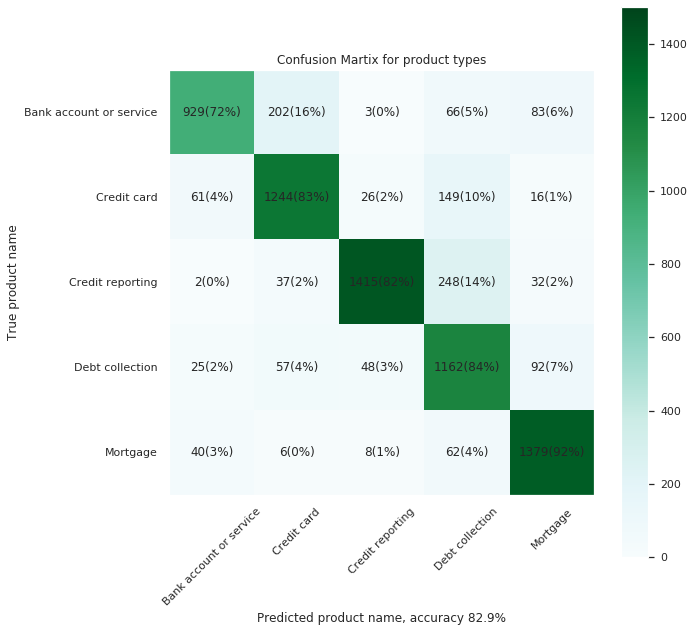

In [113]:
cmap = plt.get_cmap('BuGn')
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Confusion Martix for product types")
plt.colorbar()
plt.tight_layout()
plt.ylabel('True product name')
plt.xlabel('Predicted product name, accuracy {0:.1f}%'.format(acc_score*100))
tick_marks = np.arange(len(labels.columns))
plt.xticks(tick_marks, labels.columns, rotation=45)
plt.yticks(tick_marks, labels.columns)
plt.grid(False)
plt.clim(0,1500)
for (j,i),label in np.ndenumerate(cm):
    plt.text(i,j, "{0}({1:.0f}%)".format(label, label/total_products_by_type[j]*100),ha='center',va='center')
    #ax2.text(i,j,label,ha='center',va='center')
plt.show()

In [71]:
cm

array([[ 929,  202,    3,   66,   83],
       [  61, 1244,   26,  149,   16],
       [   2,   37, 1415,  248,   32],
       [  25,   57,   48, 1162,   92],
       [  40,    6,    8,   62, 1379]])

In [74]:
acc_score

0.8291396103896104

array([1283, 1496, 1734, 1384, 1495])